## Import libs

In [30]:
import numpy as np
import seaborn as sb
%matplotlib inline 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import confusion_matrix
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA as PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from time import time

import os
import cv2

## Dataset class for data processing

In [31]:
class Dataset():
    def __init__(self, data_path, transform) -> None:
        self.data_path = data_path
        self.transform = transform
        self.image_pairs = []
        self.labels = []

    def get_all_data(self):
        all_pairs = []
        for label in os.listdir(self.data_path):
            image_data_dir = os.path.join(self.data_path, label)
            for pair_dir in os.listdir(image_data_dir):
                identity_photos_dir = os.path.join(image_data_dir, pair_dir)
                pair = os.listdir(identity_photos_dir)
                pair_tuple = (os.path.join(identity_photos_dir, pair[0]), os.path.join(identity_photos_dir, pair[1]))
                self.image_pairs.append(pair_tuple)
                self.labels.append(label)
                all_pairs.append({'img1':os.path.join(identity_photos_dir, pair[0]), 'img2':os.path.join(identity_photos_dir, pair[1]), label: label})
        
        return all_pairs

    def get_item(self, idx):
        img1_path, img2_path = self.image_pairs[idx]
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        
        def transform_img(img, size=(96,96)):
            grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(grey_img, size)
            normalized_img = cv2.normalize(resize_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            return normalized_img
            
        if self.transform:
            return transform_img(img1), transform_img(img2), self.labels[idx]
        
        return img1, img2, self.label[idx]
    
    def calc_dist_euclidean(self, img1, img2):
        distance = np.sqrt((img1-img2)**2)
        return distance
    
    def calc_dist_simi(self, img1, img2):
        return ssim(img1, img2, data_range=img1.max()-img1.min())
    
    def calc_dist_absolute(self, img1, img2):
        return np.absolute(img1-img2)
    
    def calc_dist_cosine(self, img1, img2):
        return np.dot(img1, img2)/(np.linalg.norm(img1) - np.linalg.norm(img2))
    
    def __len__(self):
        return len(self.image_pairs)

## get data

In [32]:
data_path = '../data/'
dataset = Dataset(data_path, transform=True)
all_data = dataset.get_all_data()

## Reduction of features with PCA

In [42]:
def all_images(all_data, dataset, n=25000):
    X = []
    y = []
    for i in range(n):
        img1, img2, label = dataset.get_item(i)
        image_dist = np.array(dataset.calc_dist_euclidean(img1, img2))
        X.append(image_dist.flatten())
        y.append(label)

    for i in range(int(len(all_data)/2), int(len(all_data)/2+n)):
        img1, img2, label = dataset.get_item(i)
        image_dist = np.array(dataset.calc_dist_euclidean(img1, img2))
        X.append(image_dist.flatten())
        y.append(label)

    return X, y

X, y = all_images(all_data, dataset, 10000)

In [43]:
n_components = 10
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)
X_reduced = np.array(X_reduced)
y = np.array(y)

## Data split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.15, random_state=42)
print(len(X_train), len(X_test))
print(X_train.shape)

17000 3000
(17000, 10)


## Training

In [35]:
param_grid = {
    'n_neighbors': [50, 70, 100, 120, 135, 150, 300],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2'], 
}
clf= KNN(weights='uniform')
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3, return_train_score=True, n_jobs=6)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 2/5] END metric=euclidean, n_neighbors=50;, score=(train=0.580, test=0.522) total time=   0.7s
[CV 5/5] END metric=euclidean, n_neighbors=50;, score=(train=0.580, test=0.530) total time=   0.8s
[CV 1/5] END metric=euclidean, n_neighbors=50;, score=(train=0.579, test=0.536) total time=   0.8s
[CV 3/5] END metric=euclidean, n_neighbors=50;, score=(train=0.574, test=0.532) total time=   0.8s
[CV 4/5] END metric=euclidean, n_neighbors=50;, score=(train=0.573, test=0.536) total time=   0.8s
[CV 1/5] END metric=euclidean, n_neighbors=70;, score=(train=0.570, test=0.536) total time=   0.8s
[CV 3/5] END metric=euclidean, n_neighbors=70;, score=(train=0.568, test=0.532) total time=   0.7s
[CV 4/5] END metric=euclidean, n_neighbors=70;, score=(train=0.570, test=0.533) total time=   0.7s
[CV 5/5] END metric=euclidean, n_neighbors=70;, score=(train=0.571, test=0.539) total time=   0.7s
[CV 2/5] END metric=euclidean, n_neighbors=70;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'metric': ['euclidean', 'manhattan', 'l1', 'l2'],
                         'n_neighbors': [50, 70, 100, 120, 135, 150, 300]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [36]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_knn = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 150}
Best Cross-Validation Score: 0.5397058823529411


In [37]:
import pandas as pd

file = 'knn_scores.txt'
scores = pd.DataFrame(grid_search.cv_results_)
scores.to_csv(file)

In [45]:
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      1512
           1       0.57      0.36      0.44      1488

    accuracy                           0.55      3000
   macro avg       0.55      0.55      0.53      3000
weighted avg       0.55      0.55      0.53      3000



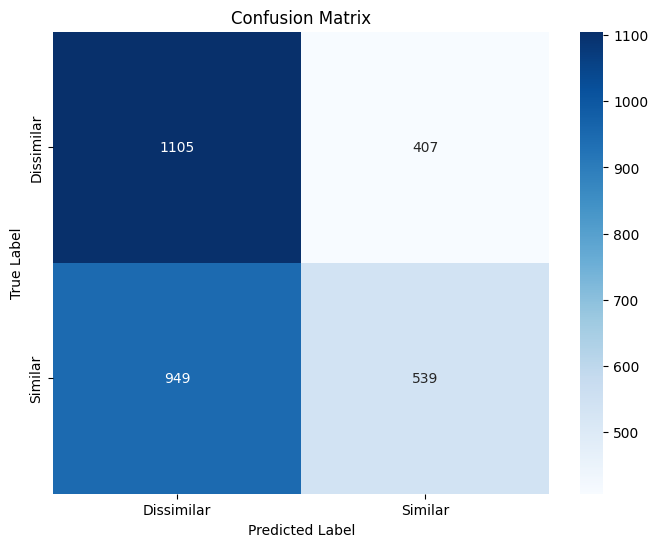

In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [47]:
print("acc: ", accuracy_score(y_test, y_pred))
#print(y_pred)
#print(y_test)
print("f1_score: ", f1_score(y_test, y_pred, pos_label='1'))
print("precision: ", precision_score(y_test, y_pred, pos_label='1'))
print("recall: ", recall_score(y_test, y_pred, pos_label='1'))

acc:  0.548
f1_score:  0.4428923582580115
precision:  0.5697674418604651
recall:  0.36223118279569894


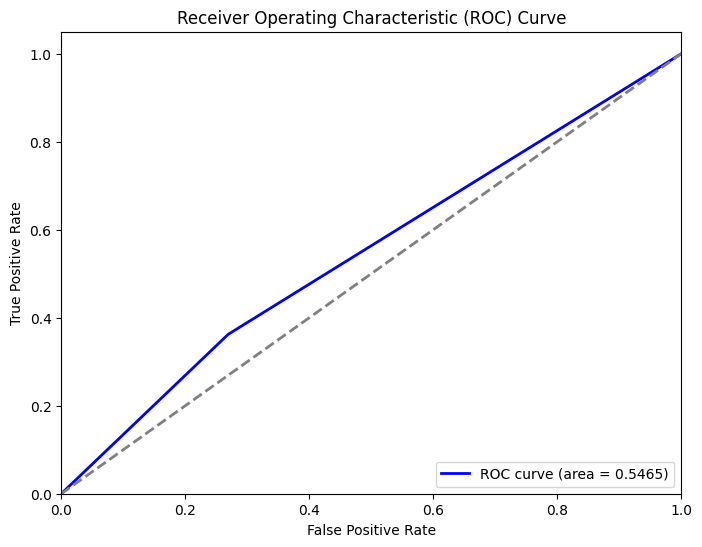

In [48]:
fpr, tpr, _ = roc_curve(y_test.astype(int), y_pred.astype(int))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [49]:
import pickle
with open('best_knn.pkl', 'wb') as file:
    pickle.dump(clf, file)